<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/notebooks/jaiio/modelos/02-lr%2Bsvm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression+SVM

En esta notebook se presetan los experimentos a partir de los datos etiquetados automáticamente a partir de las _features_ extraidas del train dataset con la estrategia de LR y SVM.

Para ello vamos a preprocesar los correos y aplicar:
- Bag of words,
- Pesado binario/no binario,
- Máquina de vector soporte (SVM).


## 1. Instalación y Carga de librerías y funciones útiles

### 1.1 Instalación de librerías

Se instalan las librerías que no están en el entorno de Google Colab:

In [1]:
# Se instala gensim que es el que tiene el modelo Word2Vec
!pip install requests
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9675 sha256=6fdc44eff6e4b6b4429f184e1e381edc31c7fd46035d72cf0aa2a80d07e66212
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


### 1.2 Funciones útiles

Se cargan funciones útiles desde el repo https://github.com/jumafernandez/clasificacion_correos para la carga y balanceo del dataset.

In [2]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import get_clases, cargar_dataset, consolidar_df

También se carga la función para preprocesar el texto que se usó en los otros modelos desde el repo: https://github.com/jumafernandez/clasificacion_correos.

In [3]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_preprocesamiento.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_preprocesamiento.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_preprocesamiento import preprocesar_correos

### 1.3. Carga de datos

Se carga el dataframe en memoria con el preprocesamiento de los datos:

In [4]:
import warnings
from os import path
warnings.filterwarnings("ignore")

# Constantes con los datos
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/consolidados/'

# Prueba:
# 1. dataset-lr-50-boosting-prep.csv
TRAIN_FILE = 'dataset-lr-100-boosting-prep.csv'
TEST_FILE = 'correos-test-jaiio-20.csv'

# Chequeo sobre si los archivos están en el working directory
download_files = not(path.exists(TRAIN_FILE))

etiquetas = get_clases()

# Defino la cantidad de clases a utilizar
CANTIDAD_CLASES = len(etiquetas)

train_df, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

# Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
import pandas as pd
train_df['consulta'] = pd.Series(preprocesar_correos(train_df['consulta']))
test_df['consulta'] = pd.Series(preprocesar_correos(test_df['consulta']))

# Muestro salida por consola
print('Existen {} clases: {}.'.format(len(train_df.clase.unique()), train_df.clase.unique()))

Se inicia descarga de los datasets.

El conjunto de entrenamiento tiene la dimensión: (1600, 25)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 16 clases: ['Boleto Universitario' 'Cambio de Carrera' 'Cambio de Comisión'
 'Consulta por Equivalencias' 'Consulta por Legajo'
 'Consulta sobre Título Universitario' 'Cursadas' 'Datos Personales'
 'Exámenes' 'Ingreso a la Universidad' 'Pedido de Certificados'
 'Problemas con la Clave' 'Reincorporación' 'Requisitos de Ingreso'
 'Simultaneidad de Carreras' 'Situación Académica'].


Me guardo la columna del score de Elasticsearch para no generar incompatibilidades:

In [5]:
score = train_df['score']
train_df.drop('score', inplace=True, axis=1)

train_df.shape

(1600, 24)

## 2. SVM

### 2.1. Carga de librerías de procesamiento de texto

Se cargan en memoria dos funciones: _grid_search_por_estrategia_representacion_ que va a iterar ajustando los hiperparámetros para las técnica de __SVM__ y _representacion_documentos_ que genera representaciones para las _features textuales_:

In [6]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_clasificacion_texto.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_clasificacion_texto.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_clasificacion_texto import gridsearch_por_estrategia_representacion, representacion_documentos

### 2.2 Modelo general (clasificación en las 16 clases)

En primer lugar se trabaja con un único clasificador que clasifica y testea las instancias en las 16 clases posibles.

#### 2.2.1 Definición del espacio de búsqueda

Se define el espacio de búsqueda para el ajuste de hiperparámetros del modelo:

In [7]:
# Defino una lista con los esquemas de representación
estrategias_representacion = ['BINARIO', 'TFIDF', '3-4-NGRAM-CHARS', '1-2-NGRAM-WORDS']
modelo = 'SVM'

# Defino los parámetros para GridSearchCV
params_svm = {'SVM__C': [0.1, 1, 10, 100], 
              'SVM__gamma': [0.01, 0.1, 1],
              'SVM__class_weight': [None, 'balanced'],
              'SVM__kernel': ['rbf', 'linear', 'poly', 'sigmoid']
              }

Se ejecuta el ajuste de hiperparámetros para cada estrategia de representación en función del espacio de búsqueda:

In [8]:
NO_CORRIDA = False

if NO_CORRIDA:
  for estrategia in estrategias_representacion:
    # Llamo a la función que realiza el gridsearch por estrategia  
    gridsearch_por_estrategia_representacion(train_df, test_df, estrategia, modelo, params_svm, None, atr_consulta='consulta')

#### 2.2.2 Modelo generado

En función de los mejores hiperparámetros encontrados con la búsqueda Grid, ajusto el modelo para obtener las métricas (por un bug en la función ya solucionado):

In [9]:
# Mejores Parámetros según GridSearchCV:
# DOCS = 50
# Parámetros: {'SVM__C': 1, 'SVM__class_weight': None, 'SVM__gamma': 0.1, 'SVM__kernel': 'sigmoid', 'clasificador': 'SVM',
# 'estrategia': 'BINARIO', 'accuracy': 0.615, 'precision': 0.49068136724386724, 'recall': 0.5869106901393801, 
# 'f1_score': 0.47251064170249846}
# DOCS = 100
# Parámetros: {'SVM__C': 1, 'SVM__class_weight': None, 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'clasificador': 'SVM',
# 'estrategia': '3-4-NGRAM-CHARS', 'accuracy': 0.655, 'precision': 0.5621298329938036, 'recall': 0.6454585001906941, 
# 'f1_score': 0.5446431414717685}

params_svm = {'SVM__C': [1], 
              'SVM__gamma': [0.01],
              'SVM__class_weight': [None],
              'SVM__kernel': ['sigmoid'],
              'SVM__probability': [True]
              }

clf, X_test, y_test = gridsearch_por_estrategia_representacion(train_df, test_df, '3-4-NGRAM-CHARS', 'SVM', params_svm, None, atr_consulta='consulta')

Estrategia de representación: 3-4-NGRAM-CHARS
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.6min finished


Estrategia de representación: 3-4-NGRAM-CHARS
Parámetros: {'SVM__C': 1, 'SVM__class_weight': None, 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'SVM__probability': True, 'clasificador': 'SVM', 'estrategia': '3-4-NGRAM-CHARS', 'accuracy': 0.655, 'precision': 0.5621298329938036, 'recall': 0.6454585001906941, 'f1_score': 0.5446431414717685}
Accuracy Test-Set: 0.655
Métricas sobre Test-Set: {'SVM__C': 1, 'SVM__class_weight': None, 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'SVM__probability': True, 'clasificador': 'SVM', 'estrategia': '3-4-NGRAM-CHARS', 'accuracy': 0.655, 'precision': 0.5621298329938036, 'recall': 0.6454585001906941, 'f1_score': 0.5446431414717685}


Se predicen las instancias de testeo:

In [10]:
y_pred = clf.predict(X_test)

Además, se utiliza el método _predict\_proba_ para calcular la probabilidad asociada a la clasificación de cada instancia:

In [11]:
import numpy as np

y_pred_proba = np.around(clf.predict_proba(X_test), 2)

y_max_proba = np.amax(y_pred_proba, 1)

In [12]:
y_max_proba

array([0.63, 0.36, 0.54, 0.33, 0.97, 0.62, 0.36, 0.5 , 0.72, 0.29, 0.86,
       0.35, 0.56, 0.99, 0.97, 0.36, 0.9 , 1.  , 0.92, 0.21, 0.31, 0.63,
       0.83, 0.86, 0.75, 0.36, 0.5 , 0.56, 0.34, 0.95, 0.31, 0.82, 0.79,
       0.9 , 0.94, 0.61, 0.97, 0.36, 1.  , 0.36, 0.49, 0.68, 0.42, 0.39,
       0.96, 0.91, 0.39, 0.41, 0.8 , 0.62, 0.4 , 0.69, 0.99, 0.88, 0.49,
       0.94, 0.59, 0.34, 0.35, 0.26, 0.31, 0.95, 0.72, 0.88, 0.54, 0.65,
       0.88, 0.71, 0.9 , 0.41, 0.48, 0.96, 0.86, 0.54, 0.77, 0.37, 0.74,
       0.96, 0.84, 0.95, 0.91, 0.6 , 0.44, 0.85, 0.56, 0.97, 0.48, 0.37,
       0.35, 0.89, 0.92, 0.97, 0.29, 0.35, 0.78, 0.4 , 0.31, 0.98, 0.23,
       0.96, 0.95, 0.94, 0.53, 0.39, 0.77, 0.87, 0.67, 0.37, 0.98, 0.44,
       0.92, 0.37, 0.63, 0.86, 0.96, 0.96, 0.6 , 0.64, 0.98, 0.64, 0.26,
       0.53, 0.25, 0.71, 0.98, 0.47, 0.35, 0.32, 0.91, 0.91, 0.82, 0.88,
       0.35, 0.74, 0.66, 0.78, 0.22, 0.63, 0.98, 0.63, 0.19, 0.36, 0.19,
       0.2 , 0.19, 0.8 , 0.28, 0.98, 0.56, 0.68, 0.

Se genera un _dataframe_ con las clases observadas para _test_, las predicciones y las probabilidades asociadas para verificar si hay relación entre las proba y los errores:

In [13]:
import pandas as pd

resultados = pd.concat([pd.Series(y_test), pd.Series(y_pred), pd.Series(y_max_proba)], axis=1)
resultados.columns = ['clase', 'prediccion', 'max_proba']
resultados['correcto'] = resultados['clase'] == resultados['prediccion']

Se calcula el _accuracy_ para las predicciones con una proba>0.5 y se obtiene una mejora sustancial:

In [14]:
sum(resultados[resultados.max_proba>0.5]['correcto'])/resultados[resultados.max_proba>0.5]['correcto'].count()

0.7265625

#### 2.2.3 Métricas de selección

##### 2.2.3.1. Matriz de confusión

A continuación, se calcula la matriz de confusión para cada clase para el recorte con proba>0.5 y para el modelo con la totalidad de instancias:

In [15]:
from sklearn import metrics #Importar el módulo metrics de scikit-learn

# Vamos a testear el modelo
print("Accuracy:", metrics.accuracy_score(resultados[resultados.max_proba>0.5]['clase'], resultados[resultados.max_proba>0.5]['prediccion']))

# Vemos un reporte de clasificación de varias métricas
print(metrics.classification_report(resultados[resultados.max_proba>0.5]['clase'], resultados[resultados.max_proba>0.5]['prediccion']))

Accuracy: 0.7265625
                                     precision    recall  f1-score   support

               Boleto Universitario       1.00      0.92      0.96        25
                  Cambio de Carrera       0.40      1.00      0.57         2
                 Cambio de Comisión       0.67      1.00      0.80         2
         Consulta por Equivalencias       0.67      1.00      0.80         2
                Consulta por Legajo       0.40      0.67      0.50         3
Consulta sobre Título Universitario       0.67      1.00      0.80         2
                           Cursadas       0.55      0.85      0.67        13
                   Datos Personales       0.00      0.00      0.00         1
                           Exámenes       1.00      0.50      0.67         4
           Ingreso a la Universidad       1.00      0.60      0.75        20
             Pedido de Certificados       0.93      0.93      0.93        14
             Problemas con la Clave       0.78      0.6

In [16]:
from sklearn import metrics #Importar el módulo metrics de scikit-learn

# Vamos a testear el modelo
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Vemos un reporte de clasificación de varias métricas
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.655
                                     precision    recall  f1-score   support

               Boleto Universitario       1.00      0.81      0.90        48
                  Cambio de Carrera       0.25      1.00      0.40         2
                 Cambio de Comisión       0.67      1.00      0.80         2
         Consulta por Equivalencias       0.33      0.67      0.44         3
                Consulta por Legajo       0.22      0.67      0.33         3
Consulta sobre Título Universitario       0.50      0.67      0.57         3
                           Cursadas       0.45      0.79      0.58        19
                   Datos Personales       0.09      0.50      0.15         2
                           Exámenes       0.75      0.60      0.67         5
           Ingreso a la Universidad       0.88      0.45      0.60        33
             Pedido de Certificados       0.93      0.93      0.93        15
             Problemas con la Clave       0.88      0.61   

In [17]:
metrics.confusion_matrix(y_test, y_pred)

array([[39,  0,  0,  0,  0,  1,  0,  5,  0,  1,  0,  0,  1,  0,  0,  1],
       [ 0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  1,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  1,  0, 15,  0,  1,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  2],
       [ 0,  2,  0,  1,  3,  0,  5,  2,  0, 15,  1,  2,  0,  0,  2,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0, 14,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  3,  0,  1,  0, 14,  1,  0,  0,  3],
       [ 0,  2,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  6,  0,  0,  1],
       [ 0,  0,  1,  0,  2,  1,  9,  0,  0,  0,  0,

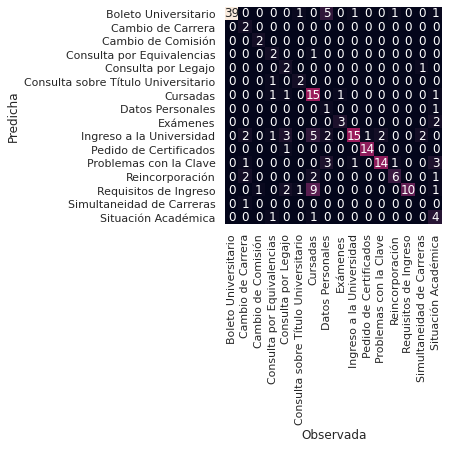

In [18]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

mat = metrics.confusion_matrix(y_test, y_pred)

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=etiquetas, yticklabels=etiquetas)

plt.xlabel('Observada')
plt.ylabel('Predicha');

### 3. Análisis del error

A continuación se intenta entender la baja de _accuracy_ para el etiquetado a partir de TF-IDF.

Para ello, se genera el dataset de train con: <br/>
| consulta | clase | score |

In [19]:
df_train_e = train_df[['consulta', 'clase']]
df_train_e['score'] = score

Genero un dataframe con los scores promedios por clase, el accuracy por clase y el _count_:

In [20]:
df_error = df_train_e.groupby(['clase']).mean().reset_index()

# Accuracy por clase
avg_class = mat.diagonal()/mat.sum(axis=1)
df_error['accuracy'] = pd.Series(avg_class)

df_error['count'] = mat.sum(axis=1)

df_error

,clase,score,accuracy,count
0,Boleto Universitario,15.737512,0.812500,48
1,Cambio de Carrera,10.049515,1.000000,2
2,Cambio de Comisión,12.130975,1.000000,2
3,Consulta por Equivalencias,9.096401,0.666667,3
4,Consulta por Legajo,13.004292,0.666667,3
5,Consulta sobre Título Universitario,10.474326,0.666667,3
6,Cursadas,10.065943,0.789474,19
7,Datos Personales,9.389950,0.500000,2
8,Exámenes,11.734265,0.600000,5
9,Ingreso a la Universidad,10.696644,0.454545,33


In [24]:
df_error[['accuracy', 'score']].corr()

,accuracy,score
accuracy,1.000000,0.155888
score,0.155888,1.000000


In [25]:
from google.colab import drive
drive.mount('drive')

df_error.to_csv('accuracy_by_class-lr.csv', index=False)
!cp accuracy_by_class-lr.csv "drive/My Drive/jaiio-prep/"



Mounted at drive


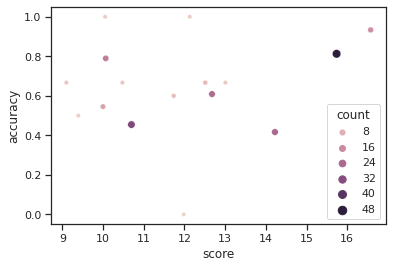

In [21]:
import seaborn as sns
sns.set_theme(style="ticks")

sns.scatterplot(data=df_error, x="score", y="accuracy", hue="count", size="count")

## Referencias
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05